https://www.tensorflow.org/tutorials/structured_data/feature_columns?hl=ko

In [1]:
#ttung102802@gmail.com
from google.colab import drive
from IPython.display import Image
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


**데이터셋**

클리블랜드(Cleveland) 심장병 재단에서 제공한 작은 데이터셋을 사용하겠습니다. 이 CSV 파일은 수백 개의 행으로 이루어져 있습니다. 각 행은 환자 한 명을 나타내고 각 열은 환자에 대한 속성 값입니다. 이 정보를 사용해 환자의 심장병 발병 여부를 예측해 보겠습니다. 즉 이 데이터셋은 이진 분류 문제입니다.

다음은 이 데이터셋에 대한 설명입니다. 수치형과 범주형 열이 모두 있다는 점을 주목하세요.

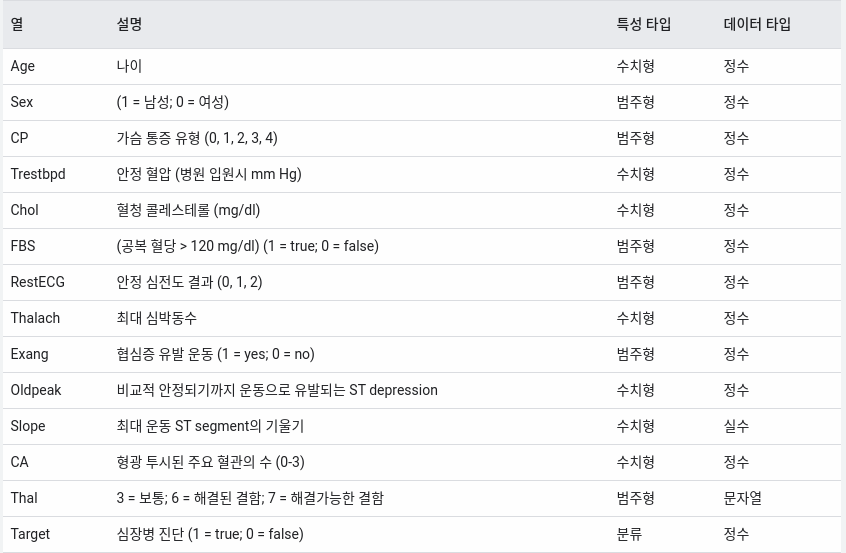

In [2]:
Image('/gdrive/My Drive/Colab Notebooks/텐서플로우 공식 튜토리얼/정형데이터 다루기 images/01.png')

# 텐서플로와 필요한 라이브러리 임포트하기

In [3]:
!pip install -q sklearn

In [4]:
import numpy as np
import pandas as pd


import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# 판다스로 데이터프레임 만들기

판다스는 정형 데이터를 읽고 조작하는데 유용한 유틸리티 함수를 많이 제공하는 파이썬 라이브러리입니다.

 판다스를 이용해 URL로부터 데이터를 다운로드하여 읽은 다음 데이터프레임으로 변환하겠습니다.

In [5]:
URL = '/gdrive/My Drive/Colab Notebooks/datas/heart.csv'
dataframe = pd.read_csv(URL)
dataframe.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [6]:
#데이터 세트 분할
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')
print(len(test), '테스트 샘플')

656 훈련 샘플
164 검증 샘플
205 테스트 샘플


# tf.data를 사용하여 입력 파이프라인 만들기

그다음 tf.data를 사용하여 데이터프레임을 감싸겠습니다. 이렇게 하면 특성 열을 사용하여 판다스 데이터프레임의 열을 모델 훈련에 필요한 특성으로 매핑할 수 있습니다. 아주 큰 CSV 파일(메모리에 들어갈 수 없을 정도로 큰 파일)을 다룬다면 tf.data로 디스크 디렉토리에서 데이터를 읽을 수 있습니다. 이런 내용은 이 튜토리얼에 포함되어 있지 않습니다.

In [7]:
# 판다스 데이터프레임으로부터 tf.data 데이터셋을 만들기 위한 함수
# tf.data 데이터셋을 만들면 매핑에 편리하다.
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  #dict내장함수는 인자를 dictionary자료형으로 바꿔준다.
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [8]:
batch_size = 5 # 예제를 위해 작은 배치 크기를 사용합니다.
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# 입력 파이프라인 이해하기

In [9]:
for feature_batch, label_batch in train_ds.take(1):
  print('전체 특성:', list(feature_batch.keys()))
  print('나이 특성의 배치:', feature_batch['age'])
  print('타깃의 배치:', label_batch )

전체 특성: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
나이 특성의 배치: tf.Tensor([51 41 66 50 55], shape=(5,), dtype=int64)
타깃의 배치: tf.Tensor([0 1 1 1 0], shape=(5,), dtype=int64)


# 여러 종류의 특성 열 알아 보기

텐서플로는 여러 종류의 특성 열을 제공합니다. 이 절에서 몇 가지 특성 열을 만들어서 데이터프레임의 열을 변환하는 방법을 알아 보겠습니다.

In [10]:
# 특성 열을 시험해 보기 위해 샘플 배치를 만듭니다.
example_batch = next(iter(train_ds))[0]

In [11]:
# 특성 열을 만들고 배치 데이터를 변환하는 함수
# 주어진 example_batch를 정해진 특성열로 변환하는 층 DenseFeatures를 선언하여 example_batch의 변환결과를 출력해준다.
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

**수치형 열**

특성 열의 출력은 모델의 입력이 됩니다(앞서 정의한 함수를 사용하여 데이터프레임의 각 열이 어떻게 변환되는지 알아 볼 것입니다). 수치형 열은 가장 간단한 종류의 열입니다. 이 열은 실수 특성을 표현하는데 사용됩니다. 이 열을 사용하면 모델은 데이터프레임 열의 값을 변형시키지 않고 그대로 전달 받습니다.

In [12]:
age = feature_column.numeric_column("age")
demo(age)

[[66.]
 [59.]
 [35.]
 [50.]
 [74.]]


**버킷형 열**

종종 모델에 수치 값을 바로 주입하기 원치 않을 때가 있습니다. 대신 수치 값의 구간을 나누어 이를 기반으로 범주형으로 변환합니다. 원본 데이터가 사람의 나이를 표현한다고 가정해 보죠. 나이를 수치형 열로 표현하는 대신 버킷형 열(bucketized column)을 사용하여 나이를 몇 개의 버킷(bucket)으로 분할할 수 있습니다. 다음에 원-핫 인코딩(one-hot encoding)된 값은 각 열이 매칭되는 나이 범위를 나타냅니다.




In [13]:
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
demo(age_buckets)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


**범주형 열**

이 데이터셋에서 thal 열은 범주형입니다(예를 들어 0(fixed),1(normal),2(reversible)). 범주형 열(categorical column)을 사용하여 문자열을 원-핫 벡터로 표현할 수 있습니다. 범주의 목록은 categorical_column_with_vocabulary_list를 사용하여 리스트로 전달하거나 categorical_column_with_vocabulary_file을 사용하여 파일에서 읽을 수 있습니다.

In [14]:
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', [0, 1, 2])

thal_one_hot = feature_column.indicator_column(thal)
demo(thal_one_hot)

[[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]]


**임베딩 열**
가능한 문자열이 몇 개가 있는 것이 아니라 범주마다 수천 개 이상의 값이 있는 경우를 상상해 보겠습니다. 여러 가지 이유로 범주의 개수가 늘어남에 따라 원-핫 인코딩을 사용하여 신경망을 훈련시키는 것이 불가능해집니다. 임베딩 열(embedding column)을 사용하면 이런 제한을 극복할 수 있습니다. 고차원 원-핫 벡터로 데이터를 표현하는 대신 임베딩 열을 사용하여 저차원으로 데이터를 표현합니다. 이 벡터는 0 또는 1이 아니라 각 원소에 어떤 숫자도 넣을 수 있는 밀집 벡터(dense vector)입니다. 임베딩의 크기(아래 예제에서는 8입니다)는 튜닝 대상 파라미터입니다.

핵심 포인트: 범주형 열에 가능한 값이 많을 때는 임베딩 열을 사용하는 것이 최선입니다. 여기에서는 예시를 목적으로 하나를 사용하지만 완전한 예제이므로 나중에 다른 데이터셋에 수정하여 적용할 수 있습니다.

In [15]:
# 임베딩 열의 입력은 앞서 만든 범주형 열입니다.
thal_embedding = feature_column.embedding_column(thal, dimension=8)
demo(thal_embedding)

[[ 0.21451205  0.3864362  -0.35230452 -0.17985179 -0.17904879 -0.05608276
  -0.46090633 -0.23322654]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.21451205  0.3864362  -0.35230452 -0.17985179 -0.17904879 -0.05608276
  -0.46090633 -0.23322654]]


**해시 특성 열**

가능한 값이 많은 범주형 열을 표현하는 또 다른 방법은 categorical_column_with_hash_bucket을 사용하는 것입니다. 이 특성 열은 입력의 해시(hash) 값을 계산한 다음 hash_bucket_size 크기의 버킷 중 하나를 선택하여 문자열을 인코딩합니다. 이 열을 사용할 때는 어휘 목록을 제공할 필요가 없고 공간을 절약하기 위해 실제 범주의 개수보다 훨씬 작게 해시 버킷(bucket)의 크기를 정할 수 있습니다.

핵심 포인트: 이 기법의 큰 단점은 다른 문자열이 같은 버킷에 매핑될 수 있다는 것입니다. 그럼에도 실전에서는 일부 데이터셋에서 잘 작동합니다.




In [17]:
# 해시 특성은 문자열 값에만 사용가능
#   thal_hashed = feature_column.categorical_column_with_hash_bucket(
#             'thal', hash_bucket_size=1000)
#   demo(feature_column.indicator_column(thal_hashed))

**교차 특성 열**

여러 특성을 연결하여 하나의 특성으로 만드는 것을 교차 특성(feature cross)이라고 합니다. 모델이 특성의 조합에 대한 가중치를 학습할 수 있습니다. 이 예제에서는 age와 thal의 교차 특성을 만들어 보겠습니다. crossed_column은 모든 가능한 조합에 대한 해시 테이블을 만들지 않고 hashed_column 매개변수를 사용하여 해시 테이블의 크기를 선택합니다.

In [18]:
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# 사용할 열 선택하기
여러 가지 특성 열을 사용하는 방법을 보았으므로 이제 이를 사용하여 모델을 훈련하겠습니다. 이 튜토리얼의 목적은 특성 열을 사용하는 완전한 코드(예를 들면 작동 방식)를 제시하는 것이므로 임의로 몇 개의 열을 선택하여 모델을 훈련하겠습니다.

핵심 포인트: 제대로 된 모델을 만들어야 한다면 대용량의 데이터셋을 사용하고 어떤 특성을 포함하는 것이 가장 의미있는지, 또 어떻게 표현해야 할지 신중하게 생각하세요.




In [23]:
feature_columns = []

# 수치형 열
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
  feature_columns.append(feature_column.numeric_column(header))

# 버킷형 열
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 범주형 열
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', [0, 1, 2])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# 임베딩 열
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# 교차 특성 열
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

# 특성 층 만들기
특성 열을 정의하고 나면 DenseFeatures 층을 사용해 케라스 모델에 주입할 수 있습니다.




In [24]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

앞서 특성 열의 작동 예를 보이기 위해 작은 배치 크기를 사용했습니다. 여기에서는 조금 더 큰 배치 크기로 입력 파이프라인을 만듭니다.

In [25]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# 모델 생성, 컴파일, 훈련

In [26]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)

Epoch 1/5
21/21 [==============================] - 4s 22ms/step - loss: 1.0504 - accuracy: 0.5838 - val_loss: 0.5768 - val_accuracy: 0.6890
Epoch 2/5
21/21 [==============================] - 0s 8ms/step - loss: 0.6248 - accuracy: 0.6692 - val_loss: 0.5477 - val_accuracy: 0.7256
Epoch 3/5
21/21 [==============================] - 0s 8ms/step - loss: 0.5664 - accuracy: 0.7058 - val_loss: 0.5451 - val_accuracy: 0.7195
Epoch 4/5
21/21 [==============================] - 0s 8ms/step - loss: 0.5476 - accuracy: 0.7409 - val_loss: 0.5179 - val_accuracy: 0.7561
Epoch 5/5
21/21 [==============================] - 0s 7ms/step - loss: 0.5166 - accuracy: 0.7424 - val_loss: 0.4862 - val_accuracy: 0.7439


In [27]:
loss, accuracy = model.evaluate(test_ds)
print("정확도", accuracy)

7/7 [==============================] - 0s 8ms/step - loss: 0.5359 - accuracy: 0.7073
정확도 0.707317054271698


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_7 (DenseFeat  multiple                 24        
 ures)                                                           
                                                                 
 dense_3 (Dense)             multiple                  131840    
                                                                 
 dense_4 (Dense)             multiple                  16512     
                                                                 
 dense_5 (Dense)             multiple                  129       
                                                                 
Total params: 148,505
Trainable params: 148,505
Non-trainable params: 0
_________________________________________________________________
